In [1]:
import time
start_time = time.time()

### Library version

In [2]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.5.
The scikit-learn version is 0.23.1.


## Get data

In [3]:
# imports
import numpy as np
import pandas as pd

# set data to df
main_df = pd.read_csv('./data/enron/03_filtered_dataset.csv', index_col=0)

In [4]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400802 entries, 0 to 400801
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   f_dir           400802 non-null  object 
 1   m_id            400802 non-null  object 
 2   m_date          400802 non-null  object 
 3   m_from          400802 non-null  object 
 4   m_to            393328 non-null  object 
 5   m_cc            111878 non-null  object 
 6   m_bcc           105896 non-null  object 
 7   m_subj          383472 non-null  object 
 8   mime_vers       400802 non-null  float64
 9   cont_type       400802 non-null  object 
 10  encode          400802 non-null  object 
 11  x_from          400802 non-null  object 
 12  x_to            395649 non-null  object 
 13  x_cc            106665 non-null  object 
 14  x_bcc           172 non-null     object 
 15  x_fold          400802 non-null  object 
 16  x_orig          400802 non-null  object 
 17  x_fname   

In [5]:
main_df.groupby(['gender']).size()

gender
0.0    226753
1.0    174049
dtype: int64

In [6]:
main_df.head(2)

,f_dir,m_id,m_date,m_from,m_to,m_cc,m_bcc,m_subj,mime_vers,cont_type,...,x_cc,x_bcc,x_fold,x_orig,x_fname,m_body,gender,clean_name,original_index,p_body
0,./data/maildir/taylor-m/all_documents/1183,<5189877.1075859905913.JavaMail.evans@thyme>,"Fri, 4 Feb 2000 03:48:00 -0800 (PST)",mark.taylor@enron.com,"raislerk@sullcrom.com, gilbergd@sullcrom.com",NaN,NaN,Web Site,1.0,text/plain; charset=us-ascii,...,NaN,NaN,\Mark_Taylor _Dec_2000\Notes Folders\All docum...,Taylor-M,mtaylor.nsf\n\n,The web site address is at the bottom.\n------...,0.0,mark taylor,375955,the web site address is at the bottom forwarde...
1,./data/maildir/whalley-l/discussion_threads/791,<32850634.1075858000673.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 06:32:00 -0800 (PST)",katherine.brown@enron.com,"james.bannantine@enron.com, cliff.baxter@enron...",NaN,NaN,Executive Committee List - Update,1.0,text/plain; charset=us-ascii,...,NaN,NaN,\Lawrence_Whalley_Dec2000\Notes Folders\Discus...,Whalley-L,gwhalley.nsf\n\n,Updates\nJennifer Burns - new cell phone numbe...,1.0,katherine brown,399010,update jennifer burn new cell phone number kat...


## Stop words, NLTK

In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{"isn't", 'so', 're', 'do', 'more', 'isn', 'weren', 'themselves', 'only', 'too', "aren't", 's', 'further', 'against', 'the', 'hers', 'these', 'on', 'your', 'herself', "should've", 'as', 'o', 'hadn', 'were', 'than', 'again', 'up', 'by', "she's", 'shouldn', 'such', 'm', 'but', 'himself', 'both', 'over', 'few', 'them', 'ma', 'yourselves', 've', 'during', "haven't", 'here', 'above', 'you', 'was', 'while', 'if', 'all', 'my', 'couldn', 'about', 'we', 'out', 'doing', 'very', 'aren', "weren't", 'itself', 'doesn', 'below', 'until', 'me', 'down', "that'll", "mightn't", 'had', 'which', 'some', 'a', "you'd", 'other', "needn't", 'once', 'in', 'there', "mustn't", 't', 'those', 'to', 'have', 'of', 'before', 'don', "wasn't", 'off', 'haven', 'mightn', "hadn't", 'from', 'is', 'd', "don't", "shan't", "it's", 'because', 'didn', 'when', 'just', 'he', 'yours', 'his', 'then', "you're", 'this', 'they', 'where', 'through', 'myself', 'theirs', 'will', 'does', 'hasn', 'needn', 'own', "won't", 'any', 'mustn', 'in

# Evaluating Classifiers

## Randomize dataframe

In [8]:
def resample_frame(df):
    df = df.sample(len(df),random_state=42).reset_index(drop=True)
    return df
main_df = resample_frame(main_df) # resampled

In [9]:
def plot_multi(df, n_samples=1000, run_these=[], CV=5):
    
    import numpy as np
    
    X = df.p_body.values[:n_samples]
    y = df.gender.values[:n_samples]

    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer()
    X = vect.fit_transform(X)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import SGDClassifier
    from sklearn.svm import LinearSVC
    from sklearn.neighbors import KNeighborsClassifier

    name_dict = {
        'RandomForestClassifier':'RFC',
        'LinearSVC': 'LSVC',
        'MultinomialNB':'MNB',
        'LogisticRegression':'LOGR',
        'SGDClassifier':'SGDC',
        'KNeighborsClassifier':'KNN',
    }
    models = [
        LogisticRegression(random_state=42),
        SGDClassifier(),
        LinearSVC(),
        RandomForestClassifier(max_depth=25, random_state=42),
        MultinomialNB(),
        KNeighborsClassifier(),
    ]
    
    # create dataframe, list for data catch
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []

    from sklearn.model_selection import cross_val_score # loop models, return accuracy
    for model in models:
        model_name = name_dict[model.__class__.__name__]
        if model_name in run_these:
            accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV, n_jobs=-1)
            for fold_idx, accuracy in enumerate(accuracies):
                entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
        sns.boxplot(x='model_name', y='accuracy', data=cv_df)
        sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                      size=8, jitter=True, edgecolor="gray", linewidth=2)
        plt.title('n_samples: {}'.format(n_samples))
        plt.grid(axis='y', which='both')
        plt.xlabel('Classifiers')

## Evaluate classifiers across multiple cv iterations, resampling

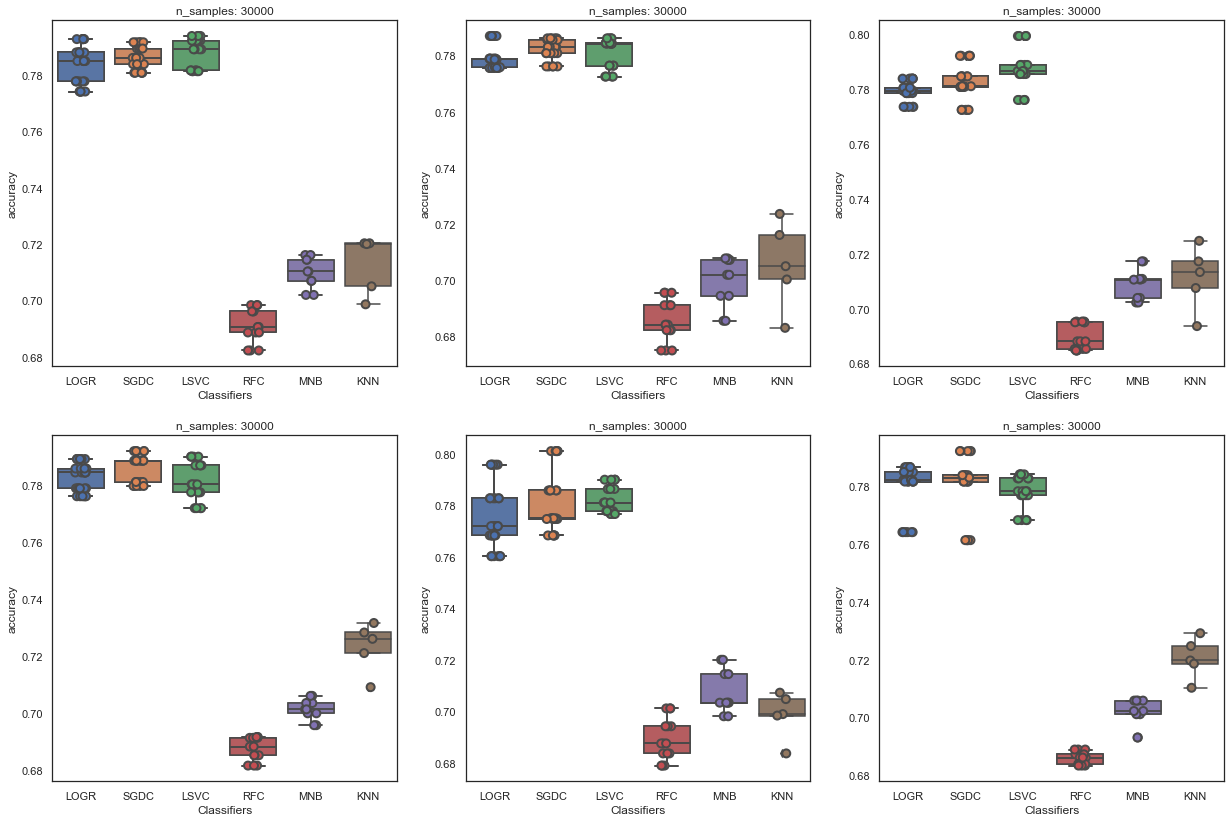

Wall time: 2min 47s


In [10]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
iter_ct = 6
iter_this = np.linspace(1,iter_ct,iter_ct)

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

run_these = ['RFC','LSVC','MNB','LOGR','SGDC','KNN']

plt.figure(figsize=(21,14), facecolor='w', edgecolor='k')
for x in iter_this:
    plt.subplot(2, 3, x)
    plot_multi(main_df, n_samples=30000, run_these=run_these)
    main_df = resample_frame(main_df)
plt.show()

## Variance across sample count

[ 60000 128160 196320 264481 332641 400802]


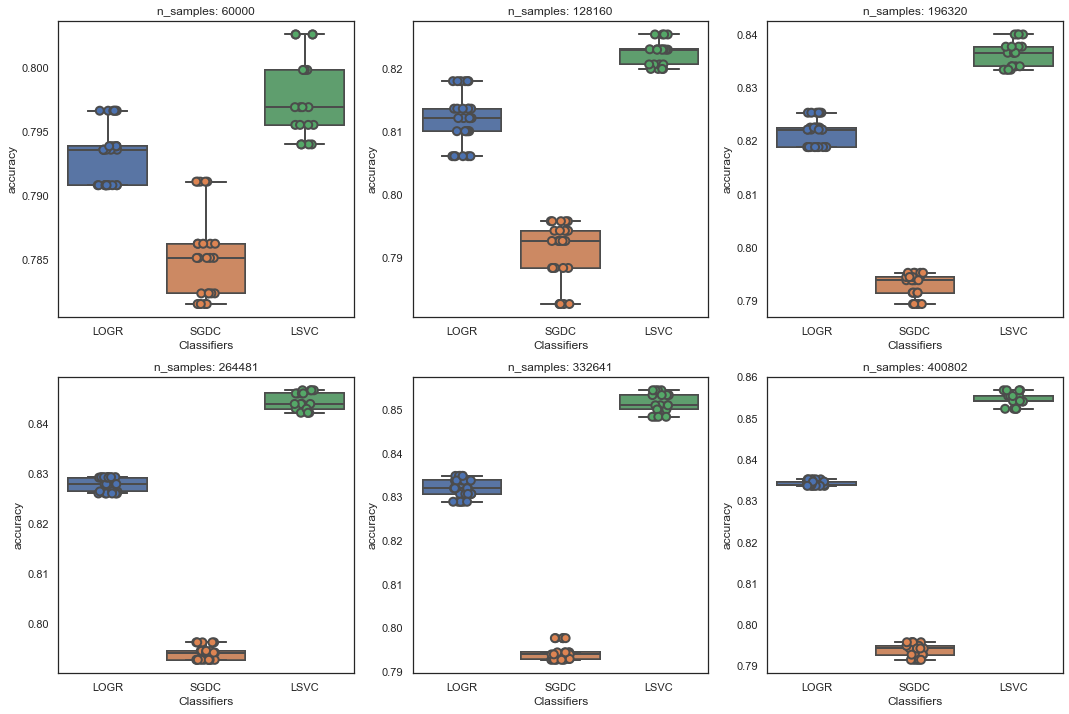

Wall time: 6min 36s


In [11]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
iter_ct = 6
iter_this = np.linspace(1,iter_ct,iter_ct)

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

run_these = ['LSVC','LOGR','SGDC']

sample_nums = np.linspace(60000, len(main_df), iter_ct).astype('int32')
#sample_nums = np.linspace(4000, 11000, iter_ct).astype('int32')
print(sample_nums)
x=1
plt.figure(figsize=(18,12), facecolor='w', edgecolor='k')
for sample_count in sample_nums:
    plt.subplot(2, 3, x)
    plot_multi(main_df, n_samples=sample_count, run_these=run_these)
    main_df = resample_frame(main_df)
    x+=1
plt.show()

> Stochastic Gradient Descent Classifier (SGDC) should have zero mean and unit variance for best performance. For now, we'll stay with Linear SVC.

# Linear support vector classification (LSVC): GridSearchCV

In [12]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def lsvc_gridsearchcv(df, n=1000, cv_n=10, test_size=0.4, random_state=42):
    
    X = df.p_body.values[:n]
    y = df.gender.values[:n]
    
    # setup pipeline, instatiate gridsearch object
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.svm import LinearSVC
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    steps = [
        ('vect', TfidfVectorizer()),
        ('lsvc', LinearSVC())
    ]
    pipeline = Pipeline(steps)    
    parameters = {
        'vect__min_df':[0.01],
        'vect__max_df':[0.99],
        'vect__stop_words':[stop_words],
        'vect__token_pattern':[r"\w{3,15}"],
        'lsvc__C':[ 0.1,  1.,  5., 7.5, 10.],
        'lsvc__max_iter':[5000],
    }
    lsvc_cv = GridSearchCV(pipeline, param_grid=parameters, cv=cv_n, n_jobs=-1)
    
    # train, fit
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    lsvc_cv.fit(X_train, y_train)
    print('Tuned LSVC Parameters: {}'.format(lsvc_cv.best_params_))
    print('Tuned LSVC Accuracy: {}'.format(lsvc_cv.best_score_))
    
    return lsvc_cv.best_params_

def lsvc_best_run(lsvc_best, n=1000):
    # get smaller sample
    X = main_df.p_body.values[:n]
    y = main_df.gender.values[:n]

    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer(        
        min_df=lsvc_best['vect__min_df'],
        max_df=lsvc_best['vect__max_df'],
        stop_words=lsvc_best['vect__stop_words'],
        token_pattern=lsvc_best['vect__token_pattern'],
    )
    X = vect.fit_transform(X)
    from sklearn.svm import LinearSVC
    model = LinearSVC(
        C=lsvc_best['lsvc__C'],
        max_iter=lsvc_best['lsvc__max_iter'],
    )
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    from sklearn.metrics import plot_roc_curve
    plot_roc_curve(model, X_test, y_test)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return vect, model, X

import regex as re
def visualizer(vect, model, X, list_n=30):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib import rcParams
    sns.set_style("whitegrid")
    sns.set_context("notebook")
    import regex as re

    def plot_ecdf(x, xlab='', ylab='', title='', logx=False, logy=False, vline=None):
        x = np.sort(x)
        n = x.size
        y = np.arange(1, n+1) / n
        plt.scatter(x, y)
        plt.xlabel(xlab, fontsize=14)
        plt.ylabel(ylab, fontsize=14)
        plt.title(title)
        if logx == True:
            plt.xscale('log')
        if logy == True:
            plt.yscale('log')
        if vline is not None:
            plt.axvline(vline, color='r', linestyle='--')
        
    def plot_scatter(x, y, xlab='', ylab='', title='', logx=False, logy=False, ):
        plt.scatter(x, y, alpha=0.25)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.title(title)
        if logx == True:
            plt.xscale('log')
        if logy == True:
            plt.yscale('log')

    model_name = model.__class__.__name__

    # GET DATA
import regex as re
def visualizer(vect, model, X, list_n=30):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib import rcParams
    sns.set_style("whitegrid")
    sns.set_context("notebook")
    import regex as re

    # GET DATA
    fn = vect.get_feature_names()
    fi = model.coef_[0] # get importance values from model output
    _ = pd.DataFrame(zip(fn, fi))
    _.columns = ['feature_name', 'feature_score']

    model_name = model.__class__.__name__

    # GET DATA
    _ = _.sort_values('feature_score', ascending=False)
    # plot lower feature importance
    plt.figure(figsize=(16,24)) # longer plot for word list
    plt.subplot(1, 2, 1)
    plt.plot(_.feature_score[:-(list_n+1):-1].values, [x for x in range(len(_.feature_score[:-(list_n+1):-1].values))], color='r') # values to xaxis
    plt.yticks(range(len(_.feature_name[:-(list_n+1):-1])), _.feature_name[:-(list_n+1):-1], fontsize=14) # labels to y-axis
    plt.ylim(list_n-1,0) # flip y-axis to descending
    plt.title('%s: Lowest %d Feature Importance' % (model_name, list_n), fontsize=16)
    
    # plot upper feature importance
    plt.subplot(1, 2, 2)
    plt.plot(_.feature_score[:list_n].values, [x for x in range(len(_.feature_score[:list_n].values))]) # values to xaxis
    plt.yticks(range(len(_.feature_name[:list_n])), _.feature_name[:list_n], fontsize=14) # labels to y-axis
    plt.ylim(list_n-1,0) # flip y-axis to descending
    plt.title('%s: Highest %d Feature Importance' % (model_name, list_n), fontsize=16)
    plt.show()    

    print()
    print(_[:list_n])
    print()
    print(_[:-(list_n+1):-1])
    print()

In [13]:
%%time
lsvc_best = lsvc_gridsearchcv(main_df, n=180000)

Tuned LSVC Parameters: {'lsvc__C': 1.0, 'lsvc__max_iter': 5000, 'vect__max_df': 0.99, 'vect__min_df': 0.01, 'vect__stop_words': {"isn't", 'so', 're', 'do', 'more', 'isn', 'weren', 'themselves', 'only', 'too', "aren't", 's', 'further', 'against', 'the', 'hers', 'these', 'on', 'your', 'herself', "should've", 'as', 'o', 'hadn', 'were', 'than', 'again', 'up', 'by', "she's", 'shouldn', 'such', 'm', 'but', 'himself', 'both', 'over', 'few', 'them', 'ma', 'yourselves', 've', 'during', "haven't", 'here', 'above', 'you', 'was', 'while', 'if', 'all', 'my', 'couldn', 'about', 'we', 'out', 'doing', 'very', 'aren', "weren't", 'itself', 'doesn', 'below', 'until', 'me', 'down', "that'll", "mightn't", 'had', 'which', 'some', 'a', "you'd", 'other', "needn't", 'once', 'in', 'there', "mustn't", 't', 'those', 'to', 'have', 'of', 'before', 'don', "wasn't", 'off', 'haven', 'mightn', "hadn't", 'from', 'is', 'd', "don't", "shan't", "it's", 'because', 'didn', 'when', 'just', 'he', 'yours', 'his', 'then', "you'r

## Linear SVC, Run best parameters

[[77687 13060]
 [22685 46889]]
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81     90747
         1.0       0.78      0.67      0.72     69574

    accuracy                           0.78    160321
   macro avg       0.78      0.77      0.77    160321
weighted avg       0.78      0.78      0.77    160321

Wall time: 1min


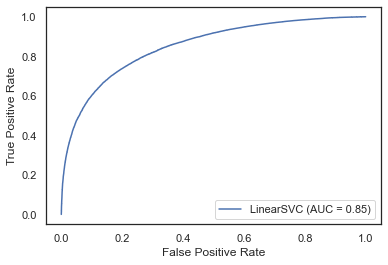

In [14]:
%%time
vect, model, X = lsvc_best_run(lsvc_best, len(main_df))

## LinearSVC, Review features

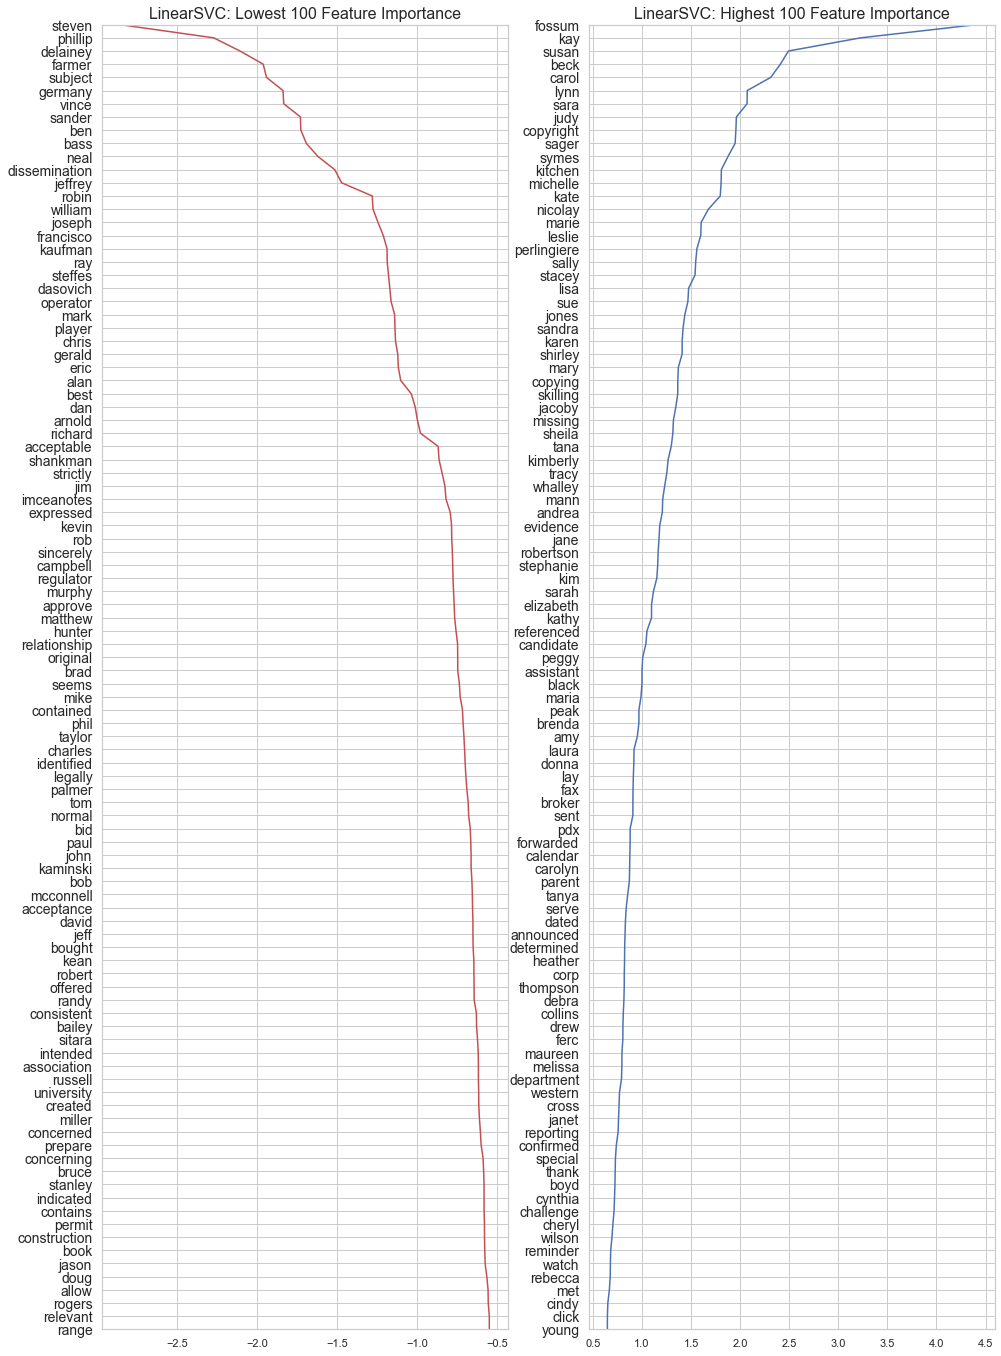


     feature_name  feature_score
523        fossum       4.406103
696           kay       3.228284
1311        susan       2.492257
137          beck       2.410237
205         carol       2.312676
...           ...            ...
1074      rebecca       0.677228
821           met       0.668437
232         cindy       0.652928
241         click       0.648533
1482        young       0.648165

[100 rows x 2 columns]

     feature_name  feature_score
1281       steven      -2.855919
968       phillip      -2.272935
354      delainey      -2.108218
484        farmer      -1.963336
1294      subject      -1.943100
...           ...            ...
397          doug      -0.566243
42          allow      -0.558264
1150       rogers      -0.557181
1100     relevant      -0.550563
1062        range      -0.550459

[100 rows x 2 columns]



In [15]:
visualizer(vect, model, X, list_n=100)

# Logistic regression (logreg): GridSearchCV

In [16]:
def logreg_gridsearchcv(df, n=1000, cv_n=10, test_size=0.4, random_state=42):

    X = df.p_body.values[:n]
    y = df.gender.values[:n]
    
    # setup pipeline
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import Pipeline
    steps = [
        ('vect', TfidfVectorizer()),
        ('logreg', LogisticRegression()),
    ]
    pipeline = Pipeline(steps)

    # Create the hyperparameter grid
    c_space = np.logspace(-5, 8, 5)
    parameters = {
        'vect__min_df':[0.01],
        'vect__max_df':[0.99],
        'vect__token_pattern':[r"\w{3,15}"],
        'vect__stop_words':[stop_words],
        'logreg__C': c_space, 
        'logreg__solver': ['lbfgs','saga'],
        'logreg__max_iter':[1000],
    }
    # train, fit, predict
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model = GridSearchCV(pipeline, param_grid=parameters, cv=cv_n, n_jobs=-1)
    model.fit(X_train, y_train)

    # print, return params
    print('Tuned Logreg Parameters: {}'.format(model.best_params_))
    print('Tuned Logreg Accuracy: {}'.format(model.best_score_))
    
    return model.best_params_


def logreg_best_run(logreg_best, n=1000):
    
    X = main_df.p_body.values[:n]
    y = main_df.gender.values[:n]
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer(
        min_df=lsvc_best['vect__min_df'],
        max_df=lsvc_best['vect__max_df'],
        token_pattern=lsvc_best['vect__token_pattern'],
        stop_words=lsvc_best['vect__stop_words'],
    )
    X = vect.fit_transform(X)
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(
        C=logreg_best['logreg__C'],
        solver=logreg_best['logreg__solver'],
        max_iter=logreg_best['logreg__max_iter'],
    )
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    from sklearn.metrics import plot_roc_curve
    plot_roc_curve(model, X_test, y_test)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return vect, model, X

In [17]:
%%time
logreg_best = logreg_gridsearchcv(main_df, n=180000)

Tuned Logreg Parameters: {'logreg__C': 31.622776601683793, 'logreg__max_iter': 1000, 'logreg__solver': 'saga', 'vect__max_df': 0.99, 'vect__min_df': 0.01, 'vect__stop_words': {"isn't", 'so', 're', 'do', 'more', 'isn', 'weren', 'themselves', 'only', 'too', "aren't", 's', 'further', 'against', 'the', 'hers', 'these', 'on', 'your', 'herself', "should've", 'as', 'o', 'hadn', 'were', 'than', 'again', 'up', 'by', "she's", 'shouldn', 'such', 'm', 'but', 'himself', 'both', 'over', 'few', 'them', 'ma', 'yourselves', 've', 'during', "haven't", 'here', 'above', 'you', 'was', 'while', 'if', 'all', 'my', 'couldn', 'about', 'we', 'out', 'doing', 'very', 'aren', "weren't", 'itself', 'doesn', 'below', 'until', 'me', 'down', "that'll", "mightn't", 'had', 'which', 'some', 'a', "you'd", 'other', "needn't", 'once', 'in', 'there', "mustn't", 't', 'those', 'to', 'have', 'of', 'before', 'don', "wasn't", 'off', 'haven', 'mightn', "hadn't", 'from', 'is', 'd', "don't", "shan't", "it's", 'because', 'didn', 'when

## Logreg, run optimized parameters

[[77196 13551]
 [21915 47659]]
              precision    recall  f1-score   support

         0.0       0.78      0.85      0.81     90747
         1.0       0.78      0.69      0.73     69574

    accuracy                           0.78    160321
   macro avg       0.78      0.77      0.77    160321
weighted avg       0.78      0.78      0.78    160321



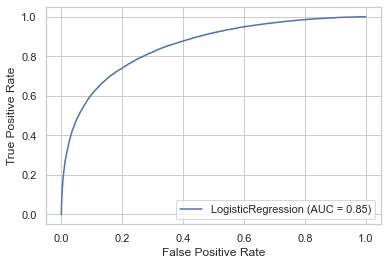

In [18]:
vect, model, X = logreg_best_run(logreg_best, n=len(main_df))

## Logreg, Review features

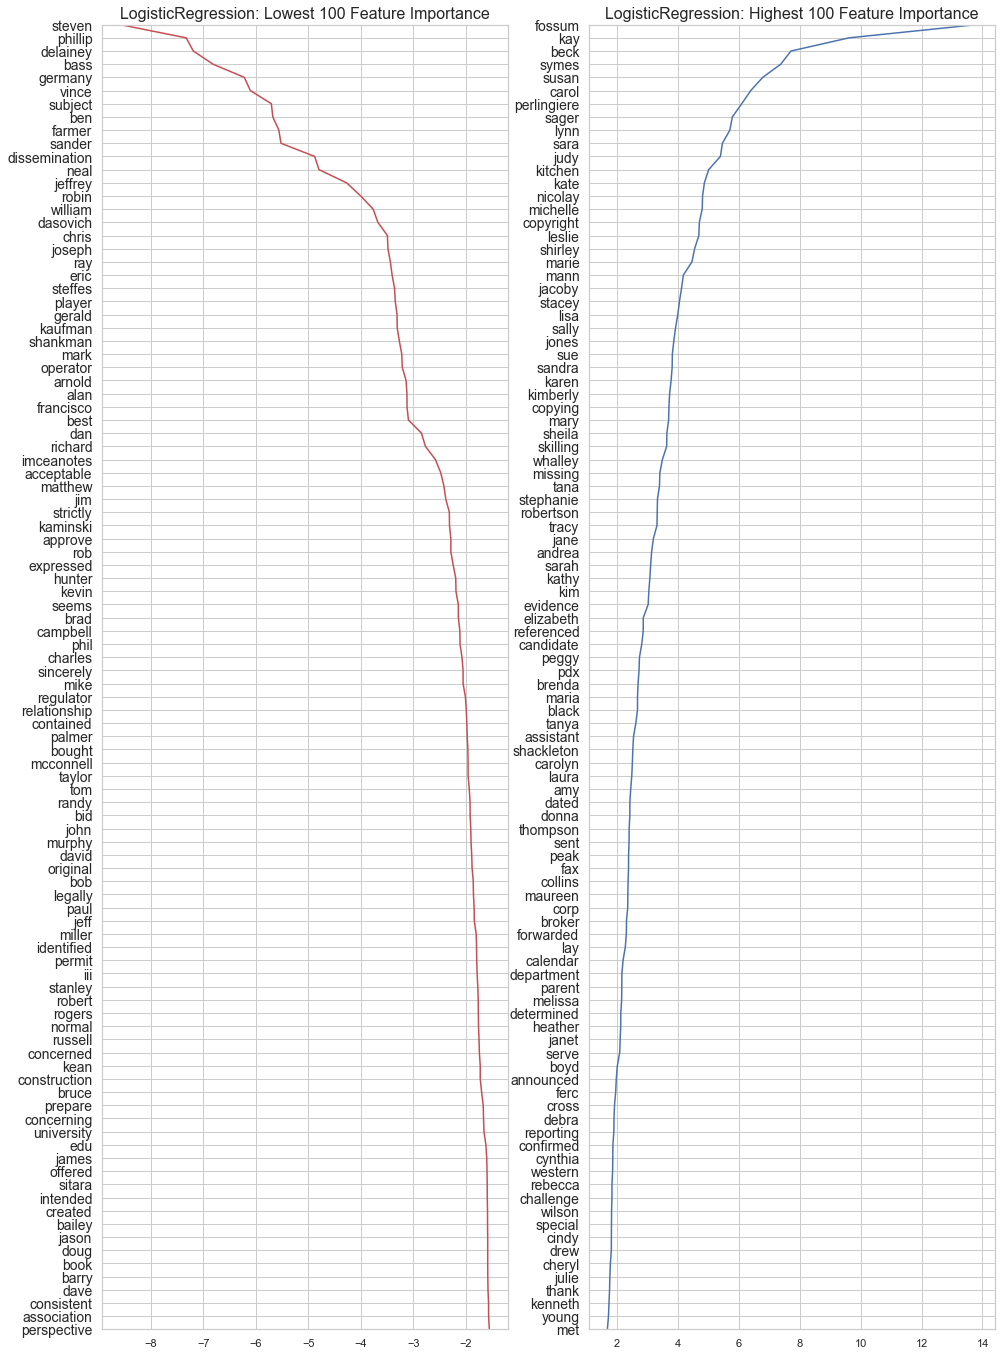


     feature_name  feature_score
523        fossum      13.797006
696           kay       9.622840
137          beck       7.717132
1314        symes       7.382228
1311        susan       6.791782
...           ...            ...
688         julie       1.777976
1343        thank       1.767065
702       kenneth       1.749025
1482        young       1.732224
821           met       1.695736

[100 rows x 2 columns]

     feature_name  feature_score
1281       steven      -8.582274
968       phillip      -7.328879
354      delainey      -7.192673
136          bass      -6.816980
551       germany      -6.221389
...           ...            ...
132         barry      -1.580837
338          dave      -1.577100
281    consistent      -1.566213
105   association      -1.565388
964   perspective      -1.551669

[100 rows x 2 columns]



In [19]:
visualizer(vect, model, X, list_n=100)

## Ending Stats

In [20]:
# execution time
print("--- {:1.2f} seconds ---".format(time.time() - start_time))

--- 1147.48 seconds ---
